# Importing Libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error,confusion_matrix,classification_report
from tqdm import tqdm_notebook 
from time import time
import pylab as pl
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.datasets import fetch_olivetti_faces 
from sklearn.preprocessing import OneHotEncoder
#from sklearn.datasets import make_blobs
import random
import math
from sklearn.preprocessing import StandardScaler
import time
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report

np.random.seed(0)

# Functions Definitions

In [0]:
def accuracy_n(y_hat, y,topk=(1,)):
  maxk = max(topk)
  batch_size = y.size(0)

  _, pred = y_hat.topk(maxk, 1, True, True)
  pred = pred.t()
  correct = pred.eq(y.view(1, -1).expand_as(pred))

  res = []
  for k in topk:
      correct_k = correct[:k].view(-1).float().sum(0)
      res.append(correct_k.mul_(100.0 / batch_size))

  return res

def euclideanDistance(x,y):
  distance = 0
  for i in range(x.size):
    distance += (x[i] - y[i])**2
  return np.sqrt(distance)

def first_comes_first(arr,x):
    arr[1:] = arr[0:-1]
    arr[0] = x
    return arr

def kNN(test_data,train_data,train_class,k):
  test_pred = np.zeros(test_data.shape[0])
  for i in range(test_data.shape[0]):
    dist_arr = np.asarray(np.zeros(k))
    nearest = np.asarray(np.zeros(k))
    ret_arr = np.array([])
    for j in range(k):
      dist_arr[j] = euclideanDistance(train_data[j],test_data[i])
      nearest[j]=j

    for j in range(train_data.shape[0]):
      temp_dist = euclideanDistance(test_data[i],train_data[j])
      if(temp_dist <= np.amin(dist_arr)):
        dist_arr = first_comes_first(dist_arr,temp_dist)
        nearest = first_comes_first(nearest,j)

    for j in (nearest):
      ret_arr = np.append(ret_arr,train_class[int(j)])
    ret_arr = np.array([int(q) for q in ret_arr])
    test_pred[i] = np.argmax(np.bincount(ret_arr))

  return test_pred

def getAccuracy(testSet, predictions):
  correct = 0
  testSet = np.array(testSet)
  for x in range(testSet.shape[0]):
    if (testSet[x] == predictions[x]):
      correct += 1
  return (correct/float(testSet.shape[0])) * 100.0

def run_kNN(X_train,X_test,Y_train,Y_test,k=[1,2,3,4,5],save_fig = False, save_dir='Output-images/',save_name='Confusion_matrix_kNN'):

  acc_arr = np.zeros(len(k))
  Y_pred = np.array([])
  max_acc = 0
  for i in range(len(k)):
    if(k[i] == 0):
      continue
    else:
      test_pred = kNN(X_test, X_train, Y_train, k[i])
      acc_arr[i] = (getAccuracy(test_pred, Y_test))
      print(k[i], acc_arr[i])
  acc_arr = np.array(acc_arr)
  Y_pred = kNN(X_test, X_train, Y_train, k[np.argmax(acc_arr)])
  print("Maximum accuracy obtained for k={} : {}".format(k[np.argmax(acc_arr)],np.amax(acc_arr)))

  cm = confusion_matrix(Y_test, Y_pred)
  #print(cm)
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(cm)
  plt.title('Confusion matrix of the classifier')
  fig.colorbar(cax)
  #ax.set_xticklabels([''] + labels)
  #ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  if(save_fig):
    plt.savefig(save_dir+save_name+'.png')
  else:
    plt.show()

  return Y_pred, np.amax(acc_arr)  
# SVM
def run_SVM(X_train_scaled,X_test_scaled,Y_train,Y_test, print_details = False,cv = 5,save_fig = False, save_dir='Output-images/',save_name='Confusion_matrix_SVM',grid_search=True,kernel=None,gamma=None,C=None):
  if(grid_search):
    params_grid = [{'kernel': ['rbf'], 'gamma': [1, 0.1, 0.01, 1e-3, 0.005, 1e-4],
                        'C': [1, 10, 100, 500, 600,  725, 750, 775, 800, 900, 1000]},
                        {'kernel': ['linear'], 'C': [1, 10, 50, 100, 200, 500, 750, 1000]}]
  else:
    params_grid = [{'kernel': [kernel], 'gamma': [gamma],
                        'C': [C]}]
  svm_model = GridSearchCV(SVC(), params_grid, cv=cv)
  svm_model.fit(X_train_scaled, Y_train)
  final_model = svm_model.best_estimator_
  Y_pred = final_model.predict(X_test_scaled)
  
  print("Training set score for SVM: %f" % final_model.score(X_train_scaled , Y_train))
  print("Testing  set score for SVM: %f" % final_model.score(X_test_scaled  , Y_test ))

  if(print_details):
    print('Best score for training data:', svm_model.best_score_,"\n") 

    # View the best parameters for the model found using grid search
    print('Best C:',svm_model.best_estimator_.C,"\n") 
    print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
    print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")
    print(confusion_matrix(Y_test,Y_pred))
    print("\n")
    print(classification_report(Y_test,Y_pred))
    svm_model.score

  cm = confusion_matrix(Y_test, Y_pred)
  #print(cm)
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(cm)
  plt.title('Confusion matrix of the classifier')
  fig.colorbar(cax)
  #ax.set_xticklabels([''] + labels)
  #ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  if(save_fig):
   plt.savefig(save_dir+save_name+'.png')
  else:
    plt.show()
  return Y_pred, final_model.score(X_test_scaled  , Y_test )*100, final_model

"""It helps visualising the portraits from the dataset."""
def plot_portraits(images, h, w, n_row, n_col):
  plt.figure(figsize=(2.2 * n_col, 2.2 * n_row))
  plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)
  for i in range(n_row * n_col):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(())

def pca(X, n_pc):
  n_samples, n_features = X.shape
  mean = np.mean(X, axis=0)
  centered_data = X-mean
  U, S, V = np.linalg.svd(centered_data)
  components = V[:n_pc]
  projected = U[:,:n_pc]*S[:n_pc]
  
  return projected, components, mean, centered_data

def reconstruction(Y, C, M, h, w, image_index):
  n_samples, n_features = Y.shape
  weights = np.dot(Y, C.T)
  centered_vector=np.dot(weights[image_index, :], C)
  recovered_image=(M+centered_vector).reshape(h, w)
  return recovered_image

def run_FFNN(X_train_scaled,X_test_scaled,Y_OH_train,Y_OH_test,Epochs=6000,save_fig = True, save_dir='Output-images/', save_name='FFNN_with_PyTorch'):
  fn = FFNNetwork_Regularized()
  loss_fn = fn.cross_entropy
  opt = optim.SGD(fn.parameters(), lr=0.9)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  X_train_scaled = X_train_scaled.to(device)
  Y_OH_train = Y_OH_train.to(device)
  fn.to(device)

  tic = time.time()
  fit(X_train_scaled, Y_OH_train, fn, opt, loss_fn, epochs=Epochs)
  toc = time.time()

  print("Time for training model: {}s".format(np.round(toc-tic,3)))

  X_test_scaled =X_test_scaled.to(device)
  Y_OH_test=Y_OH_test.to(device)
  
  for k in [1,5,10]:
    accuracy_train = fn.accuracy_n(fn.forward(X_train_scaled),Y_OH_train, topk=(k,))[0].item()
    print('Training Accuracy (top-{}): {}'.format(k,accuracy_train))


    accuracy_test = fn.accuracy_n(fn.forward(X_test_scaled),Y_OH_test, topk=(k,))[0].item()
    print('Testing Accuracy (top-{}): {}'.format(k,accuracy_test))
    print('\n')
    
  cm = confusion_matrix(torch.argmax(Y_OH_test,dim=1).to("cpu").numpy(), torch.argmax(fn.forward(X_test_scaled), dim=1).to("cpu").to("cpu").detach().numpy())
  #print(cm)
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(cm)
  plt.title('Confusion matrix of the classifier')
  fig.colorbar(cax)
  #ax.set_xticklabels([''] + labels)
  #ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  if(save_fig):
    plt.savefig(save_dir+save_name+'_Confusion_matrix.png')
  else:
    plt.show()    

#  if(save_model == True):
#    torch.save(fn.to("cpu").state_dict(), model_save_dir )
#    torch.save(fn.state_dict(), save_dir) # saving the model

  return fn.forward(X_test_scaled), accuracy_test, fn

def fit(x, y, model, opt, loss_fn, epochs = 1000,save_fig = True, save_dir='Output-images/', save_name='FFNN_with_PyTorch_loss'):
  
  loss_arr = []
  acc_arr = []
  for epoch in range(epochs):
    x, y = shuffle(x, y, random_state=0)
    y_hat = model.forward(x)
    loss = loss_fn(y_hat, y)
    loss_arr.append(loss.item())
    acc_arr.append(model.accuracy(y_hat,y))
    loss.backward()
    opt.step()
    opt.zero_grad()

  plt.plot(loss_arr, 'r-')
  plt.plot(acc_arr, 'b-')
  plt.xlabel("Epoch")
  plt.ylabel("Cross Entropy Loss")
  if(save_fig):
    plt.savefig(save_dir+save_name+'_loss.png')
  else:
    plt.show()      
  print('Loss before training', loss_arr[0])
  print('Loss after training', loss_arr[-1])


# Loading Data

In [3]:
images = fetch_olivetti_faces().data # there are 400 faces each of them is of 64x64=4096 pixels
n_samples = images.shape[0]
num_faces_per_person = 10
n_persons = int(images.shape[0]/num_faces_per_person)
h = 64;
w = 64;

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


In [0]:
num_faces_per_person = 10
n_test = 1
n_train = 9
test_samples = np.array([random.randrange(num_faces_per_person) for i in range(int(images.shape[0]/num_faces_per_person))])
Y_train = np.array([])
for i in range(n_persons):
  Y_train = np.append(Y_train, np.ones(n_train)*i)
Y_val = np.arange(n_persons)
ctr = 0
train_images = np.array([])
test_images = np.array([])
for i in range(images.shape[0]//num_faces_per_person):
  temp_train, temp_test = train_test_split(images[ctr:ctr+num_faces_per_person], test_size = 0.1)
  if(train_images.size == 0):
    train_images = temp_train
    test_images = temp_test
  else:
    train_images = np.row_stack((train_images,temp_train))
    test_images = np.row_stack((test_images,temp_test))
  ctr += num_faces_per_person

# weights = mean faces
mean_train_images = np.zeros((n_persons, images.shape[1])) # (40,4096)
for i in range(mean_train_images.shape[0]):
  mean_train_images[i] = np.mean(train_images[int(train_images.shape[0]//n_persons)*i:int(train_images.shape[0]//n_persons)*(i+1)], axis=0)

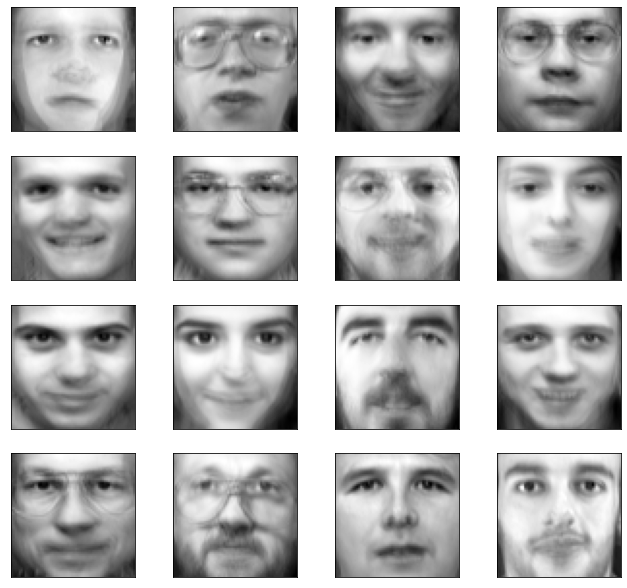

In [0]:
plot_portraits(mean_train_images, h, w, 4, 4)

# Train-Test Split

In [0]:
num_faces_per_person = 10
n_test = 1
n_train = 9
n_components = 50

Y_train = np.array([])
for i in range(n_persons):
  Y_train = np.append(Y_train, np.ones(n_train)*i)
Y_test = np.arange(n_persons)
ctr = 0

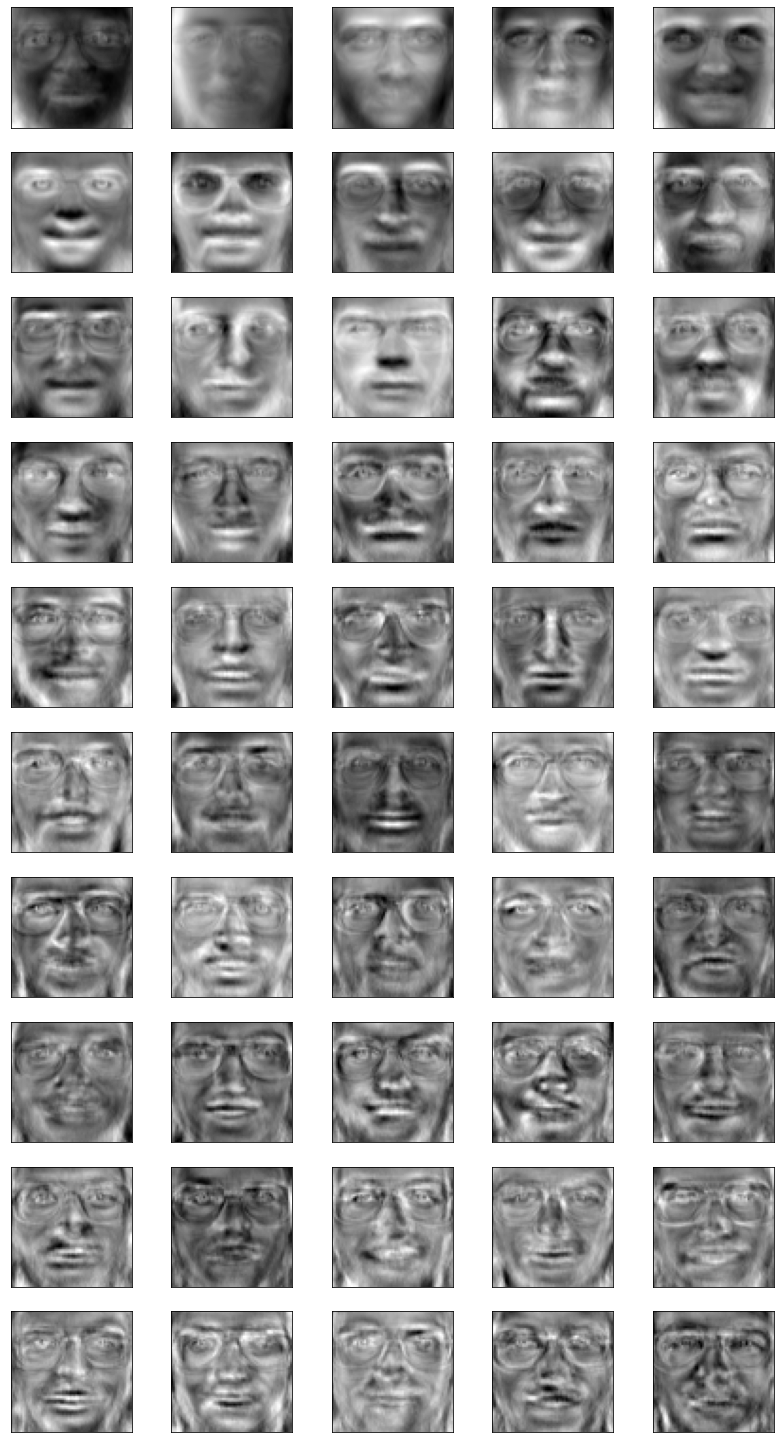

In [6]:
X = train_images
X_train, C, M, Y= pca(X, n_pc=n_components) # C -> (50,4096) P -> (360,50) M -> (1,4096) Y -> (360,4096)
eigenfaces = C.reshape((n_components, h, w)) # eigenfaces -> (50, 64, 64)
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
recovered_images=[reconstruction(test_images-M, C, M, h, w, i) for i in range(test_images.shape[0])]
plot_portraits(eigenfaces, h, w, 10, 5)

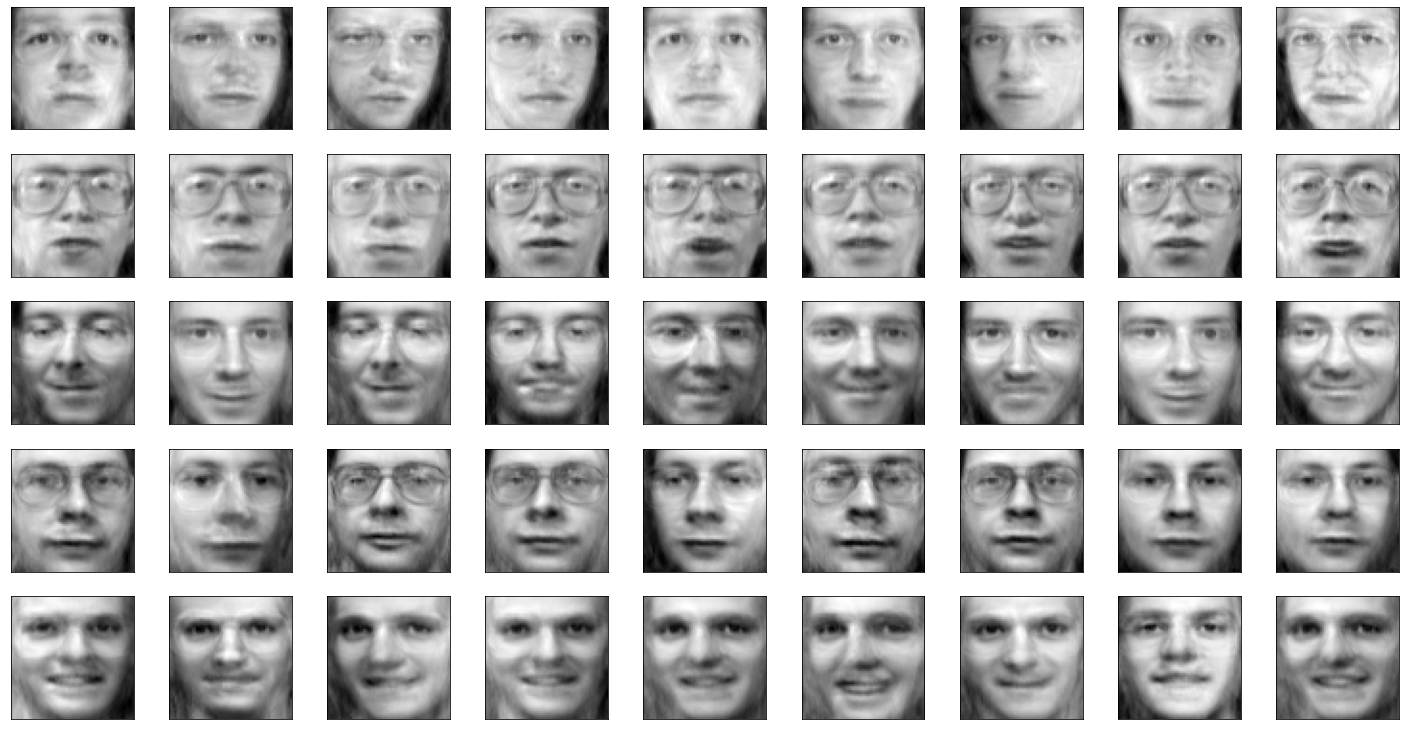

In [0]:
recovered_images=[reconstruction(Y, C, M, h, w, i) for i in range(train_images.shape[0])]
plot_portraits(recovered_images, h, w, 5, 9)

#Data Preprocessing

In [0]:
X = train_images
X_train, C, M, Y= pca(X, n_pc=n_components) # C -> (50,4096) P -> (360,50) M -> (1,4096) Y -> (360,4096)
eigenfaces = C.reshape((n_components, h, w)) # eigenfaces -> (50, 64, 64)
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
recovered_images=[reconstruction(Y, C, M, h, w, i) for i in range(train_images.shape[0])]

X_test = np.matmul(test_images-M,C.T)  # -> (40,50) = (40,4096) * (4096,50)
enc = OneHotEncoder()
Y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
Y_OH_test = enc.fit_transform(np.expand_dims(Y_test,1)).toarray()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# kNN

1 100.0
2 70.0
3 70.0
4 60.0
5 47.5
Maximum accuracy obtained for k=1 : 100.0
CPU times: user 16.8 s, sys: 531 ms, total: 17.3 s
Wall time: 16.2 s


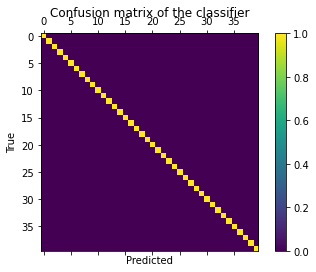

In [11]:
%%time
Y_pred_kNN, accuracy_kNN = run_kNN(X_train,X_test,Y_train,Y_test,save_fig=True)
#Y_pred_kNN, accuracy_kNN = run_kNN(X_train.to("cpu").detach().numpy(),X_test.to("cpu").detach().numpy(),Y_OH_train.to("cpu").detach().numpy(),Y_OH_test.to("cpu").detach().numpy(),k=[1])

# SVM

Training set score for SVM: 1.000000
Testing  set score for SVM: 1.000000
Best score for training data: 0.9722222222222223 

Best C: 10 

Best Kernel: rbf 

Best Gamma: 0.005 

[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         

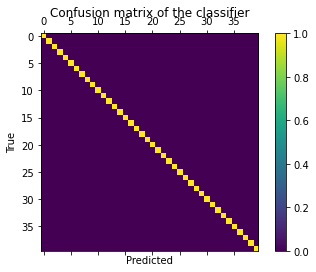

In [12]:
%%time
Y_pred_SVM, accuracy_SVM, svm_model = run_SVM(X_train_scaled,X_test_scaled,Y_train,Y_test,print_details=True,save_fig=True,grid_search=True)

# Porting to PyTorch

In [0]:
X_train,X_train_scaled, Y_OH_train, Y_train, X_test,X_test_scaled, Y_OH_test, Y_test = map(torch.tensor, (X_train,X_train_scaled, Y_OH_train, Y_train, X_test,X_test_scaled, Y_OH_test, Y_test))

X_train = X_train.float()
Y_train = Y_train.long()
X_train_scaled = X_train_scaled.float()
X_test_scaled = X_test_scaled.float()
X_test = X_test.float()
Y_test = Y_test.long()

# Training on GPU

In [0]:
# simply define a silu function
def hakuna_matata(x,x0 = 0,a=1):
  return 2/(1+torch.exp(-a*(x-x0))) - 1 # use torch.sigmoid to make sure that we created the most efficient implemetation based on builtin PyTorch functions

# create a class wrapper from PyTorch nn.Module, so
# the function now can be easily used in models
class Hakuna_Matata(nn.Module):
  def __init__(self,x0=0,a=1):
    super().__init__() # init the base class
    self.a = a
    self.x0 = x0

  def forward(self, ip):
    return hakuna_matata(ip,self.x0,self.a) # simply apply already implemented SiLU

In [0]:
class RegularizedLinear(nn.Linear):
    def __init__(self, *args, ar_weight=1e-3, l1_weight=1e-3, l2_weight=2, **kwargs):
        super(RegularizedLinear, self).__init__(*args, **kwargs)
        #self.ar_weight = ar_weight
        #self.l1_weight = l1_weight
        self.l2_weight = l2_weight
        self._losses = {}

    def forward(self, input):
        output = super(RegularizedLinear, self).forward(input)
        #self._losses['activity_regularization'] = (output * output).sum() * self.ar_weight
        #self._losses['l1_weight_regularization'] = torch.abs(self.weight).sum() * self.l1_weight
        self._losses['l2_weight_regularization'] = torch.abs(torch.mul(self.weight,self.weight)).sum() * self.l2_weight
        return output

class FFNNetwork_Regularized(nn.Module):
  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    self.net = nn.Sequential(
        #nn.Dropout(0.2),
        RegularizedLinear(n_components, 250), 
        nn.BatchNorm1d(250),
        #nn.Dropout(0.2),
        Hakuna_Matata(-1,1),
        #nn.Tanh(),
        RegularizedLinear(250,150), 
        nn.BatchNorm1d(150),
        nn.Dropout(0.2),
        Hakuna_Matata(-1,1),
        #nn.Tanh(),
        RegularizedLinear(150, 48), 
        nn.BatchNorm1d(48),
        #nn.Dropout(0.04),
        Hakuna_Matata(-1,1),
        #nn.Tanh(),   
        RegularizedLinear(48, n_persons), 
        nn.BatchNorm1d(n_persons),
#        nn.Dropout(0.1),
        Hakuna_Matata(-1,1),
 #       RegularizedLinear(n_persons,n_persons),
 #       nn.BatchNorm1d(n_persons),
#        nn.Dropout(0.1),
 #       Hakuna_Matata(-1,1),
        #nn.Tanh(),   
        nn.Softmax()
    )

  def forward(self, X):
    return self.net(X)

  def softmax(self,x):
    return torch.exp(x)/torch.sum(torch.exp(x))

  def cross_entropy(self,pred,label):
    yl=torch.mul(pred,label)
    yl=yl[yl!=0]
    yl=-torch.log(yl)
    yl=torch.mean(yl)
    return yl

  def accuracy(self,y_hat, y):
    pred = torch.argmax(y_hat, dim=1)
    return (pred == torch.argmax(y, dim=1)).float().mean()

  def predict(self, X):
    Y_pred = self.forward(x)
    return np.array(Y_pred).squeeze()
  
  def accuracy_n(self,y_hat, y,topk=(1,)):
    maxk = max(topk)
    batch_size = y.size(0)

    _, pred = y_hat.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(torch.argmax(y, dim=1).view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
  
    return res

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Loss before training 3.7378123893132607
Loss after training 1.8988727455898835
Time for training model: 4.366s
Training Accuracy (top-1): 100.00000762939453
Testing Accuracy (top-1): 100.0


Training Accuracy (top-5): 100.00000762939453
Testing Accuracy (top-5): 100.0


Training Accuracy (top-10): 100.00000762939453
Testing Accuracy (top-10): 100.0




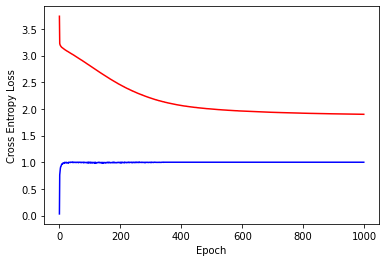

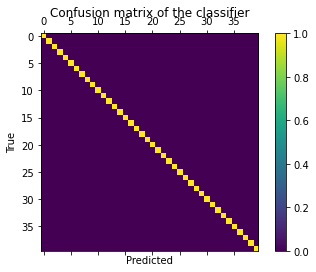

In [16]:
Y_pred_FFNN, accuracy_FFNN, model = run_FFNN(X_train_scaled,X_test_scaled,Y_OH_train,Y_OH_test,Epochs=1000,save_fig=True,save_dir='/content/')

# ENSEMBLE CLASSIFIER

Vote weighted according to individual classifier accuracy score on test data

In [0]:
# As the FFNN outputs are torch tensors and on GPU, need to convert to numpy array and port to CPU
Y_pred_FFNN = Y_pred_FFNN.to("cpu").detach().numpy()
Y_pred_FFNN = np.argmax(Y_pred_FFNN,axis=1)

In [0]:
enc = OneHotEncoder()
Y_OH_kNN = enc.fit_transform(np.expand_dims(np.append(Y_pred_kNN,np.arange(n_persons)),1)).toarray()[0:Y_pred_kNN.size]
Y_OH_SVM = enc.fit_transform(np.expand_dims(np.append(Y_pred_SVM,np.arange(n_persons)),1)).toarray()[0:Y_pred_SVM.size]
Y_OH_FFNN = enc.fit_transform(np.expand_dims(np.append(Y_pred_FFNN,np.arange(n_persons)),1)).toarray()[0:Y_pred_FFNN.size]
save_fig = True
save_dir = "Output-images/"
save_name = "Confusion_matrix_ensemble"

In [0]:
#weightage = [1/np.log(accuracy_kNN/100.0),1/np.log(accuracy_SVM/100.0),1/np.log(accuracy_FFNN/100.0)]
#weightage /= sum(weightage)
weightage = [0.3,0.3,0.4]
temp_Y_pred_ensemble = weightage[0]*Y_OH_kNN + weightage[1]*Y_OH_SVM + weightage[2]*Y_OH_FFNN 
Y_pred_ensemble = np.argmax(weightage[0]*Y_OH_kNN + weightage[1]*Y_OH_SVM + weightage[2]*Y_OH_FFNN , axis=1)

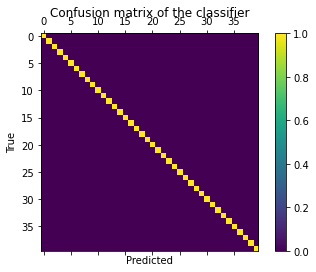

In [20]:
cm = confusion_matrix(Y_val, Y_pred_ensemble)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
if(save_fig):
  plt.savefig(save_dir+save_name+"_(kNN_SVM_FFNN).png")
else:
  plt.show()


In [24]:
for k in [1,5,10]:
    accuracy_val = accuracy_n(torch.tensor(temp_Y_pred_ensemble),Y_test, topk=(k,))[0].item()
    print('Validation Set Accuracy (top-{}): {}'.format(k,accuracy_val))


Validation Set Accuracy (top-1): 100.0
Validation Set Accuracy (top-5): 100.0
Validation Set Accuracy (top-10): 100.0


# Saving Files

In [0]:
torch.save(model.state_dict(),"/content/CLASS_FFNNetwork_fetch.txt")